In [261]:
import os
from collections import namedtuple

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

%matplotlib notebook

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

Notes:
- Mean number of products per order: 75-100
- Different pallet types in the same order
- Same container type in the same order
- Item rotation not allowed

In [110]:
def gen_products(num_products, max_lenght, max_width, max_height, max_weight):
    lenghts = np.random.uniform(low=1, high=max_lenght, size=num_products).astype(int).reshape(-1, 1)
    widths = np.random.uniform(low=1, high=max_width, size=num_products).astype(int).reshape(-1, 1)
    heights = np.random.uniform(low=1, high=max_height, size=num_products).astype(int).reshape(-1, 1)
    weights = np.random.uniform(low=1, high=max_weight, size=num_products).astype(int).reshape(-1, 1)
    data = np.concatenate((lenghts, widths, heights, weights), axis=1)
    return pd.DataFrame(data, columns=["lenght", "width", "height", "weight"])

In [338]:
# Pallet EUR 1 / Container 1A
num_products = 100
container_height, pallet_height = 2200, 145 # mm
max_lenght = 800 # mm
max_width = 1200 # mm
max_height = container_height - pallet_height # mm
max_weight = 200 # kg

In [342]:
products_path = "data/products.pkl"
if not os.path.exists(products_path):
    print("Generating products...")
    products = gen_products(num_products, max_lenght, max_width, max_height, max_weight)
    products.to_pickle(products_path)
else:
    print("Loading pickled products...")
    products = pd.read_pickle(products_path)
products.head()

Generating products...


,lenght,width,height,weight
0,170,521,1265,74
1,386,853,2019,39
2,304,148,1518,84
3,536,789,1566,110
4,770,745,1573,146


In [343]:
def get_order(products, ordered_products):
    order = products.sample(ordered_products, replace=True)
    ids = pd.Series(order.index, name="id")
    return pd.concat([ids, order.reset_index(drop=True)], axis=1)

In [344]:
ordered_products = 10

In [345]:
order = get_order(products, ordered_products)
order.head()

,id,lenght,width,height,weight
0,64,127,874,548,183
1,41,339,999,882,79
2,22,215,591,2010,93
3,19,400,1053,1223,68
4,33,616,88,807,94


In [47]:
def from_blb_to_vertices(x, y, z, l, w, h):
    blb = [x, y, z]
    blf = [x + l, y, z]
    brb = [x, y + w, z]
    brf = [x + l, y + w, z]
    
    tlb = [x, y, z + h]
    tlf = [x + l, y, z + h]
    trb = [x, y + w, z + h]
    trf = [x + l, y + w, z + h]
    
    return np.array([blb, blf, brb, brf, tlb, tlf, trb, trf])

In [58]:
def from_vertices_to_faces(v):
    return np.array([
        [v[0], v[1], v[3], v[2]], # bottom
        [v[4], v[5], v[7], v[6]], # top
        [v[0], v[2], v[6], v[4]], # back
        [v[1], v[3], v[7], v[5]], # front
        [v[0], v[1], v[5], v[4]], # left
        [v[2], v[3], v[7], v[6]], # right
    ])

In [101]:
def add_product_to_pallet(ax, blb, dims):
    v = from_blb_to_vertices(*blb, *dims)
    ax.scatter3D(v[:, 0], v[:, 1], v[:, 2])
    f = from_vertices_to_faces(v)
    ax.add_collection3d(
        Poly3DCollection(
            f, facecolors=np.random.rand(1,3), linewidths=1, edgecolors='r', alpha=.45
        )
    )
    return ax

In [310]:
def get_pallet(max_lenght, max_width, max_height):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.text(0, 0, 0, "origin", size=10, zorder=1,  color='k')
    ax.view_init(azim=60)
    ax.set_xlim3d(0, max_lenght)
    ax.set_ylim3d(0, max_width)
    ax.set_zlim3d(0, max_height)
    return ax

In [311]:
def plot_pallet(order, ids, blbs, max_lenght, max_width, max_height):
    ax = get_pallet(max_lenght, max_width, max_height)
    for i, blb in zip(ids, blbs):
        ax = add_product_to_pallet(ax, blb, (order.iloc[i].lenght, order.iloc[i].width, order.iloc[i].height))
    plt.show()
    return ax

<IPython.core.display.Javascript object>


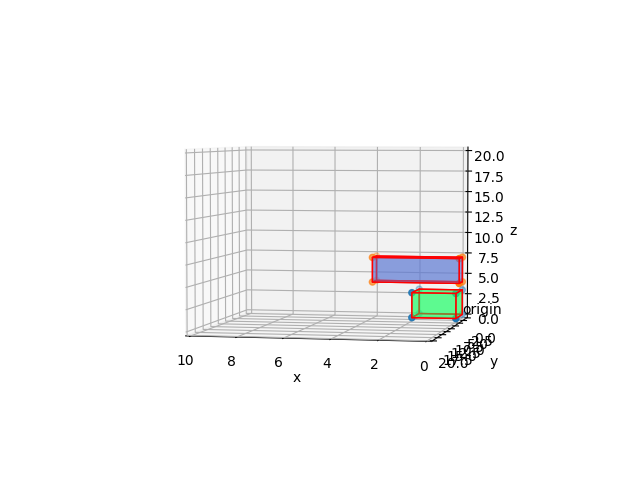

In [313]:
ax = get_pallet(10, 20, 20)
ax = add_product_to_pallet(ax, (0,0,0), (2, 4, 3))
ax = add_product_to_pallet(ax, (0,0,4), (4, 2, 3))
plt.show()

In [354]:
model = cp_model.CpModel()
max_pallets = ordered_products

Corner = namedtuple("Corner", "x y z")

# Variables
# product_in_pallet[i, j] = 1 if product i is packed in pallet j
product_in_pallet = {}
for i in range(ordered_products):
    for j in range(max_pallets):
        product_in_pallet[(i, j)] = model.NewBoolVar('product_in_pallet_%i_%i' % (i, j))
        
# pallet[i] = 1 if pallet i is used
pallet = {}
for i in range(max_pallets):
    pallet[i] = model.NewBoolVar('pallet_%i' % i)

# blb_corners[i] = [(x_s, x_e), (y_s, y_e), (z_s, z_e)] if product i has blb corner (x_s, y_s, z_s)
blb_corners_start = {}
blb_corners_end = {}
blb_corners_int = {}
for i in range(ordered_products):
    x_s = model.NewIntVar(0, max_lenght - int(order.iloc[i].lenght), 'blb_corner_x_start_%i' % i)
    y_s = model.NewIntVar(0, max_width - int(order.iloc[i].width), 'blb_corner_y_start_%i' % i)
    z_s = model.NewIntVar(0, max_height - int(order.iloc[i].height), 'blb_corner_z_start_%i' % i)
    blb_corners_start[i] = Corner(x_s, y_s, z_s)
    
    x_e = model.NewIntVar(int(order.iloc[i].lenght), max_lenght, 'blb_corner_x_end_%i' % i)
    y_e = model.NewIntVar(int(order.iloc[i].width), max_width, 'blb_corner_y_end_%i' % i)
    z_e = model.NewIntVar(int(order.iloc[i].height), max_height, 'blb_corner_z_end_%i' % i)
    blb_corners_end[i] = Corner(x_e, y_e, z_e)
    
    blb_corners_int[i] = [
        model.NewIntervalVar(x_s, int(order.iloc[i].lenght), x_e, 'blb_corner_x_int_%i' % i),
        model.NewIntervalVar(y_s, int(order.iloc[i].width), y_e, 'blb_corner_y_int_%i' % i),
        model.NewIntervalVar(z_s, int(order.iloc[i].height), z_e, 'blb_corner_z_int_%i' % i)
    ]

# prec[i, j, d] = 1 if product i precedes product j on dimension d 
prec = {}
for i in range(ordered_products):
    for j in range(i + 1, ordered_products):
        prec[(i, j)] = [
            model.NewBoolVar('%i_before_%i_x' % (i, j)),
            model.NewBoolVar('%i_before_%i_y' % (i, j)),
            model.NewBoolVar('%i_before_%i_z' % (i, j))
        ]
        
    
# Constraints
# Each product must be in exactly one pallet
for i in range(ordered_products):
    model.Add(sum(product_in_pallet[(i, j)] for j in range(max_pallets)) == 1)
    
# Preceding constraint
for i in range(ordered_products):
    for j in range(i + 1, ordered_products):
        model.Add(blb_corners_start[i].x < blb_corners_start[j].x).OnlyEnforceIf(
            prec[(i, j)][0]
        )
        model.Add(blb_corners_start[i].x >= blb_corners_start[j].x).OnlyEnforceIf(
            prec[(i, j)][0].Not()
        )
        model.Add(blb_corners_start[i].y < blb_corners_start[j].y).OnlyEnforceIf(
            prec[(i, j)][1]
        )
        model.Add(blb_corners_start[i].y >= blb_corners_start[j].y).OnlyEnforceIf(
            prec[(i, j)][1].Not()
        )
        model.Add(blb_corners_start[i].z < blb_corners_start[j].z).OnlyEnforceIf(
            prec[(i, j)][2]
        )
        model.Add(blb_corners_start[i].z >= blb_corners_start[j].z).OnlyEnforceIf(
            prec[(i, j)][2].Not()
        )
    
# Non-overlapping constraint
'''
for p in range(max_pallets):
    for i in range(ordered_products):
        for j in range(i + 1, ordered_products):
            model.Add(blb_corners_start[i].x >= blb_corners_end[j].x or blb_corners_start[j].x >= blb_corners_end[i].x).OnlyEnforceIf(
                [product_in_pallet[i, p], product_in_pallet[j, p]]
            )
            model.Add(blb_corners_start[i].y >= blb_corners_end[j].y or blb_corners_start[j].y >= blb_corners_end[i].y).OnlyEnforceIf(
                [product_in_pallet[i, p], product_in_pallet[j, p]]
            )
            model.Add(blb_corners_start[i].z >= blb_corners_end[j].z or blb_corners_start[j].z >= blb_corners_end[i].z).OnlyEnforceIf(
                [product_in_pallet[i, p], product_in_pallet[j, p]]
            )
'''
for p in range(max_pallets):
    for i in range(ordered_products):
        for j in range(i + 1, ordered_products):
            model.Add(blb_corners_start[i].x + int(order.iloc[i].lenght) <= blb_corners_start[j].x + max_lenght * (1 - prec[(i, j)][0])).OnlyEnforceIf(
                [product_in_pallet[i, p], product_in_pallet[j, p]]
            )
            model.Add(blb_corners_start[i].y + int(order.iloc[i].width) <= blb_corners_start[j].y + max_width * (1 - prec[(i, j)][1])).OnlyEnforceIf(
                [product_in_pallet[i, p], product_in_pallet[j, p]]
            )
            model.Add(blb_corners_start[i].z + int(order.iloc[i].height) <= blb_corners_start[j].z + max_height * (1 - prec[(i, j)][2])).OnlyEnforceIf(
                [product_in_pallet[i, p], product_in_pallet[j, p]]
            )

# The amount packed in each pallet cannot exceed its capacity
#for j in range(ordered_products):
#    solver.Add(
#        sum(x[(i, j)] * order.iloc[i].weight for i in range(ordered_products)) <= y[j] * 2490
#    )

# If at least one product is in a pallet, then that pallet is used
for j in range(max_pallets):
    for i in range(ordered_products):
        model.AddImplication(product_in_pallet[(i, j)], pallet[j])
    
model.Minimize(sum([pallet[i] for i in range(max_pallets)]))

Solve status: OPTIMAL
Number of pallets: 1
Pallet #9
	Products in pallet: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
	Products bottom-left-back corners: [(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]


<IPython.core.display.Javascript object>


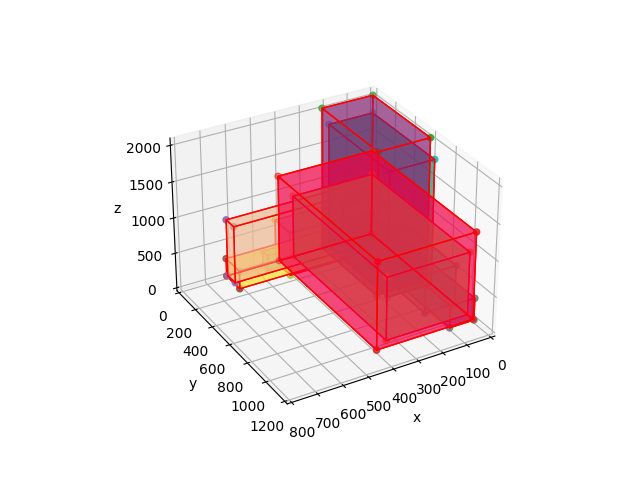


CpSolverResponse:
status: OPTIMAL
objective: 1
best_bound: 1
booleans: 199
conflicts: 0
branches: 558
propagations: 664
integer_propagations: 489
restarts: 394
lp_iterations: 0
walltime: 0.027629
usertime: 0.027628
deterministic_time: 0.000462828
primal_integral: 0.000363553



In [355]:
solver = cp_model.CpSolver()
status = solver.Solve(model)
print('Solve status: %s' % solver.StatusName(status))

if status == cp_model.OPTIMAL:
    print('Number of pallets: %i' % solver.ObjectiveValue())
    for j in range(max_pallets):
        if solver.Value(pallet[j]):
            pallet_items = []
            pallet_blbs = []
            for i in range(ordered_products):
                if solver.Value(product_in_pallet[i, j]) > 0:
                    pallet_items.append(i)
                    pallet_blbs.append((
                        solver.Value(blb_corners_start[i].x),
                        solver.Value(blb_corners_start[i].y),
                        solver.Value(blb_corners_start[i].z)
                    ))
            print(f'Pallet #{j}')
            print(f'\tProducts in pallet: {pallet_items}')
            print(f'\tProducts bottom-left-back corners: {pallet_blbs}')
            plot_pallet(order, pallet_items, pallet_blbs, max_lenght, max_width, max_height)
            print()
    print(solver.ResponseStats())
elif status == cp_model.MODEL_INVALID:
    print(model.Validate())

In [357]:
print([solver.Value(prec[(i,j)][0]) for i in range(ordered_products) for j in range(i+1, ordered_products)])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [331]:
model._CpModel__model

variables {
  name: "product_in_pallet_0_0"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_1"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_2"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_3"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_4"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_5"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_6"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_7"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_8"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_0_9"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_1_0"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_1_1"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_1_2"
  domain: 0
  domain: 1
}
variables {
  name: "product_in_pallet_1_3"
  domain: 0
  domain: 1
}
variables {
  name: 